In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle

import uncertainties as uct
from uncertainties import unumpy as unp

from scipy.optimize import curve_fit

# 1. Inverting Amplifier

### 1.1 Transfer curve by frequencies

In [ ]:

handle = open("inverting_amp_high.pkl", 'rb')
data_h=pickle.load(handle)
handle.close()

handle = open("inverting_amp_low.pkl", 'rb')
data_l=pickle.load(handle)
handle.close()

R1 = data_l["R1"]
freq = data_l["Freq"]
f = freq[6]

T, Ch1, Ch2 = data_l[f]
length = 100
T = T[:length]
Ch1 = Ch1[:length]
Ch2 = Ch2[:length]

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)

### 1.2. Transfer curve by resistances

In [ ]:
def linear(x,a,b):
    return a*x+b

def fit(x,a,b,reg1,reg2):
    reg1,reg2 = int(reg1),int(reg2)
    V1 = linear(x[reg1],a,b)
    y1 = np.full(reg1,V1)
    y2 = linear(x[reg1:-reg2],a,b)
    V2 = linear(x[-reg2],a,b)
    y3 = np.full(reg2,V2)
    y = np.concatenate((y1,y2,y3))
    return y

########## End of Function Defining ##########

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

R1 = data["R1"]
Res2 = data["R2"]
E_sat = 6

colours = plt.cm.viridis(np.linspace(0, 1, len(Res2)))

X = np.linspace(-30,10)
axs2.plot(X,X,color="black",alpha=0.01)

m_values = []
for i, R2 in enumerate(Res2):
    t,Vin,Vout = data[R2]
    
    # Vin = Vin[:200]
    # Vout = Vout[:200]
    # Sort time series by increasing Ch1 values. 
    indices = np.argsort(Vin) 
    Vin = Vin[indices]
    Vout = Vout[indices]

    E_sat = 6
    amp = -R2/R1
    trial = [amp,25e-6,1,1]
    if R2 >= 800:
        trial = [amp,25e-6,1900,1900]
    popt,pcov = curve_fit(fit,Vin,Vout,p0=trial,maxfev = 10800)
    print(popt)
    perr = np.sqrt(np.diag(pcov))
    m = -R2/R1
    axs1.plot(Vin,fit(Vin,*popt),color="black",alpha=0.3)
    if R2 >= 1000: 
        R2 /= 1000
        label = fr"{R2}k$\Omega$"
    else: label = fr"{R2}$\Omega$"
    axs1.scatter(Vin,Vout
                 ,s=0.5,alpha=0.6,color=colours[i]
                 )
    
    axs2.errorbar(m,popt[0]
                  ,label=fr"{R2}k$\Omega$"
                  ,yerr = perr[0]
                  ,fmt=">",markersize="9",color = colours[i]
                  )
axs2.legend(loc="upper left")
axs1.set_ylim(-7,7)
axs1.set_xlim(-6,6)
axs1.set_ylabel("Output Voltage (V)")
axs1.set_xlabel("Input Voltage (V)")

axs2.set_ylim(-25,5)
axs2.set_xlim(-25,5)
axs2.plot(X,X,color="black",alpha=0.2)
axs2.set_ylabel(r"Measured Gain")
axs2.set_xlabel(r"Predicted Gain")

fig.savefig("figures/inverting_slops.png")

# Individual NICs

<class 'int'>
8192 8192 8192
220 220 2200 5000
[-0.0004517969662140368, 0.004545454545454545, 25000000.0, 0.02727272727272727, 5000]
10000


ValueError: operands could not be broadcast together with shapes (10000,) (8192,) 

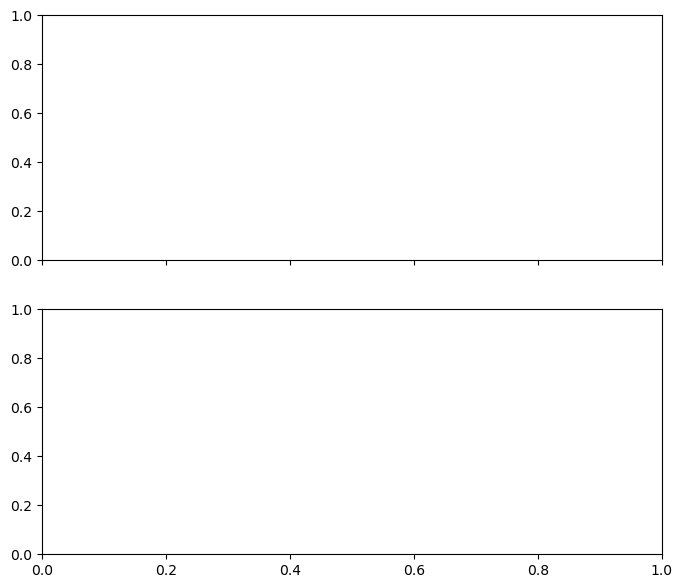

In [61]:
def linear(x,a,b):
    return a*x+b

def fit(x,aint,aext,bint,bext,reg):
    reg = int(reg)
    y1 = linear(x[:reg],aext,bext)
    y2 = linear(x[reg:-reg],aint,bint)
    y3 = linear(x[-reg:],aext,-bext)
    y = np.concatenate((y1,y2,y3))
    print(len(y))
    return np.concatenate((y1,y2,y3))

########## End of Function Defining ##########

fig,axs = plt.subplots(2,1,figsize=(8,7),sharex=True,sharey=True)

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Vcc = data["Vcc"][0]
print(type(Vcc))
A = 2000

for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    ax = axs[i]
    T,Ch1,Ch2 = data[R_i]
    print(len(T),len(Ch1),len(Ch2))
    if i==0:
        R1,R2,R3 = data["Res"][:3]
        reg = 5000
    else: 
        R1,R2,R3 = data["Res"][3:]
        reg = 1000
    print(R1,R2,R3,reg)
    m_ext = 1/R1
    m_int = ((1-A)*R2+R3)/(R1*(R2+(1+A)*R3))
    bint = 25e6
    bext = m_ext*Vcc

    trial = [m_int,m_ext,bint,bext,reg]
    print(trial)

    popt,_ = curve_fit(fit,Ch1,Ch2,p0=trial,maxfev = 2800)
    ax.scatter(Ch1,Ch2/R_i,label=fr"{R_i}$\Omega$",s=0.5,color="red")
    ax.legend(loc="lower left")

[0. 0. 0. ... 0. 0. 0.]
[ 2.97883856e-06 -1.38179204e-05 -3.06146793e-05 ...  5.33691154e-05
  3.65723564e-05  1.97755975e-05]
[-5.91393811e-05 -8.61821630e-05 -1.15408524e-04 ...  2.66920571e-05
 -3.50724843e-07 -2.95770854e-05]


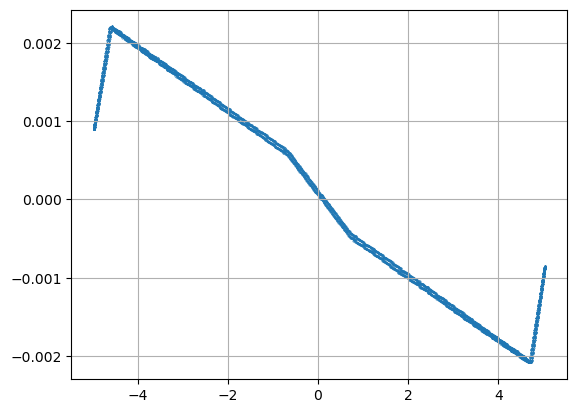

In [57]:
handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

T = np.full(len(data[220][0]),0.)
Ch2 = np.full(len(data[220][0]),0.)
print(Ch2)
for R_i in [data["Res"][0],data["Res"][3]]:
    t,ch1,ch2 = data[R_i]
    T += t
    Ch2 += ch2/R_i ;print(Ch2)
    
plt.scatter(ch1,Ch2,s=0.1)
plt.grid()